<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# Eletronics Purchase Prediction

Today you are a machine learning engineer in the Department of Marketing and Inventory at Walmart Labs. You have access to the Walmart server data, specifically the Electronics section. However, there is no customer facing information, but you do have access to timestamped data regarding product viewing/carting/purchasing. We will use this data to build a model of whether or not some product will be purchased.

Data is adapted from [e-commerce behavior data on Kaggle](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store). 

This file contains behavior data from a large multi-category store. Each row in the file represents an event. All events are related to products and users. Each event has a many-to-many relationship between users and products. 

## Learning Objectives

At the end of this session, you will be able to

- Leverage `pandas_profiling` for fast data understanding
- Practice data preprocessing
- Build logistic regression / SVM / Gradient Boosting
- Evaluate models with proper metrics
- Interpret black box models with SHAP
- Generate optimal pipeline for classification task using AutoML

## Task 1: Load data

Let's start by looking at the descriptions before loading in the csv files.

1. Use the `IPython.display` module to view the `some_column_descriptions.png` file. Look through the column names and descriptions to get an idea of what the data is.

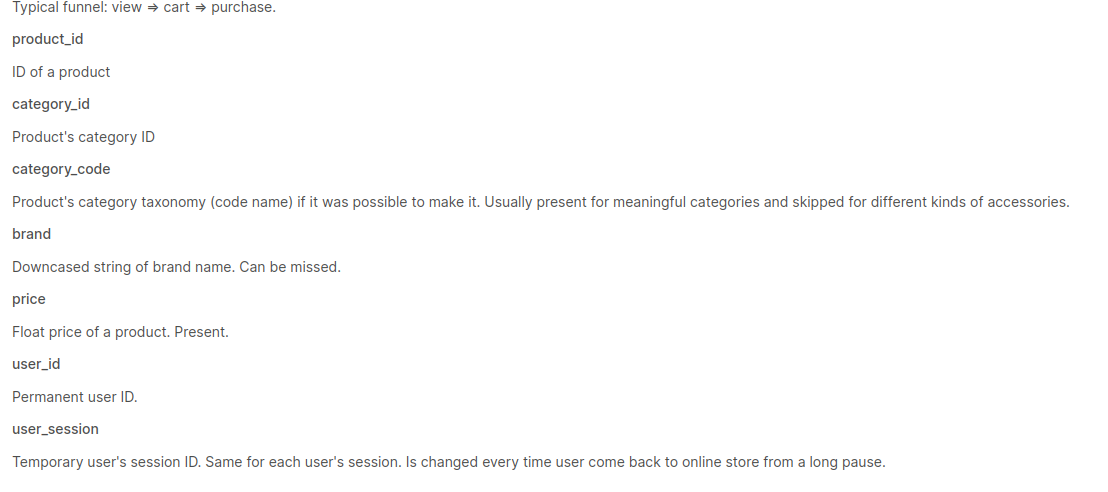

In [1]:
# description of each column
from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '../img/some_column_descriptions.png'
display(Image(filename=filename))

The dataset has User-journey data, i.e., it tracks information on user/product pairs over time to see if the combination results in a purchase.

2. Look at the `user_journey_descriptions.png` file. Review the data sample to get a sense of what information we are tracking for each user/product pair.

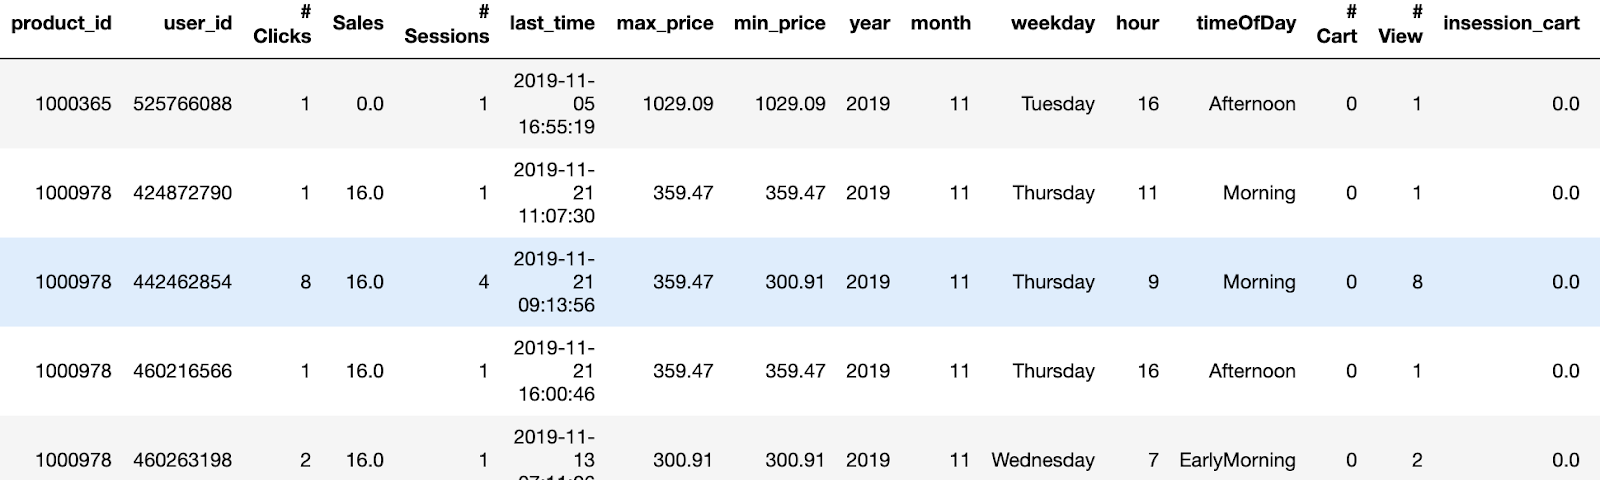

In [2]:
# change path to wherever you uploaded/downloaded the file
filename='../img/user_journey_descriptions.png'
display(Image(filename=filename))

The dataset we are working with is essentially what we have screenshotted above, but has been anonymized by removing product IDs and user IDs.

3. Use the pandas `read_csv()` and `head()` functions to read in the training data (`../dat/train.csv.gz`) and look at the first few rows.

    Note the `Purchase` column has values either 0 (not purchased) or 1 (purchased).

In [3]:
import pandas as pd
train_df = pd.read_csv('../dat/train.csv.gz')
display(train_df)
train_df.head()

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,2019,11,Sat,Morning,0,0
1,1,1,0.0,92.67,92.67,0,1,0,1,2019,11,Fr,Dawn,0,0
2,1,1,0.0,155.71,155.71,0,1,0,1,2019,11,Thu,Afternoon,0,0
3,1,1,0.0,898.32,898.32,0,1,0,1,2019,11,Mon,Noon,0,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2019,11,Tue,Noon,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645811,1,1,0.0,128.67,128.67,0,1,0,2,2019,11,Sat,EarlyMorning,0,0
645812,1,1,0.0,244.51,244.51,0,1,0,1,2019,11,Thu,EarlyMorning,0,0
645813,1,1,0.0,152.82,152.82,0,1,0,1,2019,11,Sun,EarlyMorning,0,0
645814,1,1,0.0,190.22,190.22,0,1,0,1,2019,11,Wed,Evening,0,0


,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,2019,11,Sat,Morning,0,0
1,1,1,0.0,92.67,92.67,0,1,0,1,2019,11,Fr,Dawn,0,0
2,1,1,0.0,155.71,155.71,0,1,0,1,2019,11,Thu,Afternoon,0,0
3,1,1,0.0,898.32,898.32,0,1,0,1,2019,11,Mon,Noon,0,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2019,11,Tue,Noon,0,0


4. What is the dimension of the training data?

In [4]:
train_df.shape

(645816, 15)

5. Similarly, read in the test data `../dat/test.csv.gz` and check its dimension.

In [5]:
test_df = pd.read_csv('../dat/test.csv.gz')
display(test_df)
test_df.shape

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,126.86,126.86,0,1,0,1,2019,11,Wed,EarlyMorning,0,0
1,2,2,182.0,118.38,118.38,0,2,0,1,2019,11,Fr,EarlyMorning,0,0
2,1,1,0.0,63.77,63.77,0,1,0,1,2019,11,Fr,Morning,0,0
3,1,1,0.0,32.18,32.18,0,1,0,3,2019,11,Fr,EarlyMorning,0,0
4,1,1,0.0,1093.72,1093.72,0,1,0,2,2019,11,Sat,EarlyMorning,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430539,1,1,0.0,25.48,25.48,0,1,0,1,2019,11,Wed,Evening,0,0
430540,1,1,0.0,16.47,16.47,0,1,0,1,2019,11,Sat,Morning,0,0
430541,1,1,0.0,38.61,38.61,0,1,0,2,2019,11,Thu,Evening,0,0
430542,3,2,142943.0,486.47,427.16,0,3,0,2,2019,11,Sun,Dawn,0,0


(430544, 15)

## Task 2: Understand data

Our goal here is to predict whether a customer/product pair will result in a purchase. 
To do this, we will want to identify the most important features for classification. 

Before digging into each column, let's leverage `pandas_profiling`, that goes beyond `pd.DataFrame.describe()`, to get a big picture of our data set. 

1. From `pandas_profiling` import `ProfileReport`. 
    
    For faster iteration, create a profile report object `profile` with 10,000 samples from `train_df`. 
    
    Set its `title` as "Pandas Profiling Electronics Purchase Report". 
    
    For sampling, use `pd.DataFrame.sample(10000, randome_state=3)`. 

In [6]:
# Profile Report on train df
from pandas_profiling import ProfileReport

print('\nPandas Profiling Report\n')
profile = ProfileReport( train_df.sample(10000, random_state=3) , title="Pandas Profiling Report")
profile.to_widgets()


Pandas Profiling Report



Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/wildfell/miniconda3/envs/sentiment_analysis/lib/python3.8/site-packages/multimethod/__init__.py:315: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  return func(*args, **kwargs)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

   Show the report inside the notebook, go over the report and check each tab; especially the "Alerts". 

In [7]:
%%time
profile.to_notebook_iframe()

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 1.39 s, sys: 63.2 ms, total: 1.45 s
Wall time: 1.61 s


2. Pandas profiling Profile reports that there are 5 numeric variables and 11 categorical variables. Let's print out the datatype of each feature (column) and understand how the profiler infers data type. 

In [8]:
#YOUR CODE HERE
# display([ train_df[col_i].dtypes for col_i in train_df.columns])

train_df.dtypes

NumOfEventsInJourney      int64
NumSessions               int64
interactionTime         float64
maxPrice                float64
minPrice                float64
NumCart                   int64
NumView                   int64
InsessionCart             int64
InsessionView             int64
year                      int64
month                     int64
weekday                  object
timeOfDay                object
Weekend                   int64
Purchase                  int64
dtype: object

3. From the report, we see that `year`, `month`, and `Weekend` were "Rejected" as there is only one distinct value for each column. 
These features are not informative, so we remove the three features from the training set. To do this, pass the `columns` argument to the `.drop()` method. 
Make sure to use `inplace=True` to modify the DataFrame. 
Print the shape of the DataFrames to verify the columns were dropped.

In [9]:
assert train_df.shape[1] == 15
# YOUR CODE HERE
train_df.drop(columns = ['year','month','Weekend'] , inplace=True)
assert train_df.shape[1] == 12

4. Repeat the steps for `test_df`:

In [10]:
# YOUR CODE HERE
test_df.drop(columns = ['year','month','Weekend'] , inplace=True)

assert test_df.shape[1] == train_df.shape[1]

5. As you can see from the profile report, `weekday` and `timeOfDay` each has 7 distinct values. 
Convert these non-numeric features to numeric. 

    These feature values are ordered temporally, so it makes sense to convert them to numeric type. 
    Follow the example given for the `weekday` column to update the `timeOfDay` column.
    Use the `.head()` method to inspect the dataset after the transformations.

In [11]:
weekday_str2num = {
    s: i+1 for i, s in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fr', 'Sat', 'Sun'])
}
train_df['weekday'] = train_df['weekday'].replace(weekday_str2num)
train_df['weekday'].unique()

array([6, 5, 4, 1, 2, 3, 7])

In [12]:
timeOfDay_str2num = {
    s: i+1 for i, s in enumerate( list(train_df.timeOfDay.unique()) )
}
train_df['timeOfDay'] = train_df['timeOfDay'].replace(timeOfDay_str2num)
train_df['timeOfDay'].unique()

array([1, 2, 3, 4, 5, 6, 7])

In [13]:
train_df

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,weekday,timeOfDay,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,6,1,0
1,1,1,0.0,92.67,92.67,0,1,0,1,5,2,0
2,1,1,0.0,155.71,155.71,0,1,0,1,4,3,0
3,1,1,0.0,898.32,898.32,0,1,0,1,1,4,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
645811,1,1,0.0,128.67,128.67,0,1,0,2,6,6,0
645812,1,1,0.0,244.51,244.51,0,1,0,1,4,6,0
645813,1,1,0.0,152.82,152.82,0,1,0,1,7,6,0
645814,1,1,0.0,190.22,190.22,0,1,0,1,3,5,0


6. Do the same for `test_df`, that is, to convert `weekday` and `timeOfDay` into numeric type. 

In [14]:
test_df['weekday'] = test_df['weekday'].replace(weekday_str2num)
print(test_df['weekday'].unique())

test_df['timeOfDay'] = test_df['timeOfDay'].replace(timeOfDay_str2num)
print(test_df['timeOfDay'].unique())


[3 5 6 7 2 4 1]
[6 1 3 2 5 7 4]


7. Use the `Purchase` column in training set to determine the proportion of user journeys that result in purchases.  Compare it to what the profile reports. Is the dataset balanced?

In [15]:
print("number of purchases vs non-purchases in train set:")
print(train_df.Purchase.value_counts())

print(f"percent of rows resulting in purchase: {100* train_df.Purchase.sum() / len(train_df)}") # YOUR CODE HERE

number of purchases vs non-purchases in train set:
0    636839
1      8977
Name: Purchase, dtype: int64
percent of rows resulting in purchase: 1.3900244032355966


## Task 3: Preprocess Data

Correlated features in general don't improve models (although it depends on the specifics of the problem like the number of variables and the degree of correlation), but they affect specific models in different ways and to varying extents:

- For linear models (e.g., linear regression or logistic regression), [multicolinearity](https://en.wikipedia.org/wiki/Multicollinearity) can yield [solutions that are wildly varying and possibly numerically unstable](https://en.wikipedia.org/wiki/Multicollinearity#Consequences).
- Random forest can be good at detecting interactions between different features, but highly correlated features can mask these interactions.
More generally, this can be viewed as a special case of [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor). A simpler model is preferable, and, in some sense, a model with fewer features is simpler. The concept of [minimum description length](https://en.wikipedia.org/wiki/Minimum_description_length) makes this more precise ([ref](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features)).

1. How many features does our dataset currently have?

In [16]:
# YOUR CODE HERE
n_features = len(set(train_df.columns) - set(['Purchase']))
print( f'There are { n_features } features.')

There are 11 features.


2. Drop the features with high correlation.

    In the "Correlations" tab in the profile report, you can find heatmap using five different correlation metrics; toggle correlation desciptions if any one of them looks foreign to you.  

    We'll remove high correlated features by looking at each pair of features, and if they are highly correlated (at least 0.8), we won't include the second feature in the pair. Store the remaining set of features (the ones you didn't drop) in dataframes `train_df_reduced`. You are given most the code, make sure that you understand what each line does.
    
    First, calculate the correlation with just 10,000 samples.

In [17]:
train_small_df = train_df.copy().sample(n=int(1e4), random_state=12) 
cor = train_small_df.corr()

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,weekday,timeOfDay,Purchase
NumOfEventsInJourney,1.000000,0.820386,0.502779,0.019786,0.018034,0.169965,0.562265,0.142453,0.099629,0.023316,0.010085,0.107172
NumSessions,0.820386,1.000000,0.628841,0.020670,0.018456,0.145634,0.462171,0.108800,0.028005,0.014853,0.004390,0.074800
interactionTime,0.502779,0.628841,1.000000,0.013432,0.010612,0.054007,0.316047,0.039385,0.016925,0.000565,-0.008397,0.025312
maxPrice,0.019786,0.020670,0.013432,1.000000,0.999976,-0.009437,0.017823,-0.012768,-0.022749,0.003485,0.007137,0.006733
minPrice,0.018034,0.018456,0.010612,0.999976,1.000000,-0.009691,0.016752,-0.012980,-0.022768,0.003412,0.007037,0.006693
NumCart,0.169965,0.145634,0.054007,-0.009437,-0.009691,1.000000,-0.596957,0.919035,-0.272776,0.029040,0.011485,-0.002761
NumView,0.562265,0.462171,0.316047,0.017823,0.016752,-0.596957,1.000000,-0.562690,0.345214,-0.011738,-0.003064,-0.355151
InsessionCart,0.142453,0.108800,0.039385,-0.012768,-0.012980,0.919035,-0.562690,1.000000,-0.240111,0.035035,0.010931,0.006669
InsessionView,0.099629,0.028005,0.016925,-0.022749,-0.022768,-0.272776,0.345214,-0.240111,1.000000,0.040195,0.005864,-0.171515
weekday,0.023316,0.014853,0.000565,0.003485,0.003412,0.029040,-0.011738,0.035035,0.040195,1.000000,-0.003610,0.018331


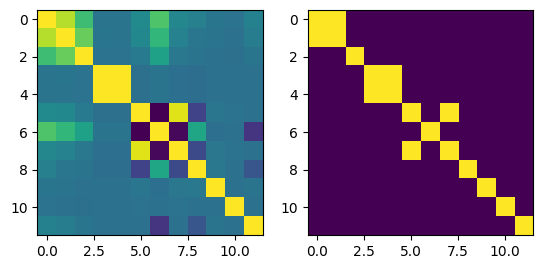

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure()
plt.subplot(1,2,1); plt.imshow(cor)
plt.subplot(1,2,2); plt.imshow(cor>=.8)

display(cor)

# Started coding before realizing that the answer is below
# for i in cor.columns:
#     for j in cor.columns:
#         if (cor.loc[i,j] >= .8) & (i != j) :
#             print([i,j])

In [19]:
import numpy as np

keep_columns = np.full(cor.shape[0], True)
for i in range(cor.shape[0] - 1):
    for j in range(i + 1, cor.shape[0] - 1):
        if (np.abs(cor.iloc[i, j]) >= 0.8):
            keep_columns[j] = False
selected_columns = train_df.columns[keep_columns]
train_df_reduced = train_df[selected_columns]

In [20]:
print(selected_columns) 

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')


3. How many columns are left in the DataFrame?

In [21]:
# YOUR CODE HERE
print(f'There are {len(train_df_reduced.columns)} columns, inculding Purchase')

There are 9 columns, inculding Purchase


In [22]:
train_df_reduced.columns

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')

4. Remove the same features from the test set and save in a new dataframe `test_df_reduced`.

In [23]:
test_df_reduced = test_df[selected_columns] # YOUR CODE HERE
assert test_df_reduced.shape[1] == 9

5. Visualize the selected features and discuss your observations with your team.

    Again, for faster rendering, use the subset `train_small_df_reduced`. If time permits, experiment with some other visualizations of the data.

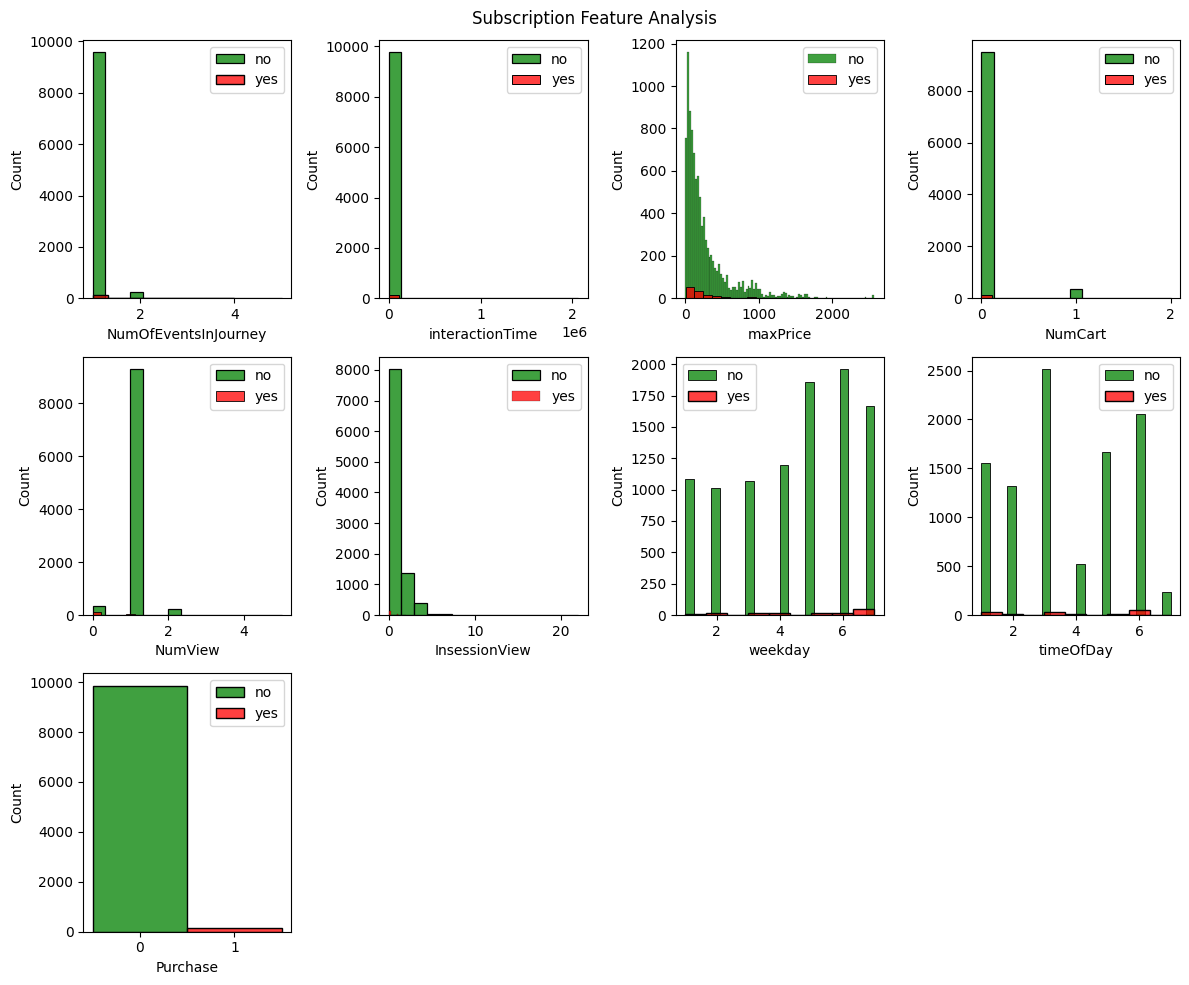

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
train_small_df_reduced = train_small_df[selected_columns]
fig = plt.figure(figsize=(12, 10))
j = 0
for i in train_df_reduced.columns:
    plt.subplot(3, 4, j + 1)
    j += 1
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 0], color='g', label='no')
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 1], color='r', label='yes')
    plt.legend(loc='best')
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95);

6. Make the NumPy arrays `X_train_reduced`, `X_test_reduced`, `y_train` and `y_test` from `train_df_reduced` and `test_df_reduced`. 

In [25]:
y_train = train_df_reduced['Purchase'].values
y_test = test_df_reduced['Purchase'].values
X_train_reduced = train_df_reduced.drop(columns='Purchase').values
X_test_reduced = test_df_reduced.drop(columns='Purchase').values

7. Scale the features in `X_train_reduced` and `X_test_reduced` use `MinMaxScaler`

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler =  MinMaxScaler( (0,1) )
scaler.fit( X_train_reduced )

X_train_reduced = scaler.transform( X_train_reduced ) 
X_test_reduced = scaler.transform( X_test_reduced ) 


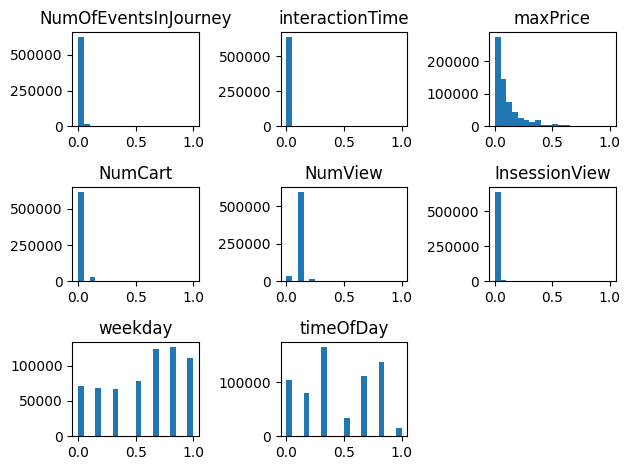

In [27]:
for col_i in pd.DataFrame( X_train_reduced ).columns:
    plt.subplot(3,3,col_i+1)
    plt.hist(pd.DataFrame( X_train_reduced )[col_i] , np.arange(0,1.05 , .05) )
    plt.title( train_df_reduced.columns[col_i] )

plt.tight_layout()

## Task 4: Build Logistic Regression and SVM models

We will be fitting both a Logistic Regression and SVM model to the reduced features and then looking at classification metrics such as Accuracy, Precision, Recall, and F1-score.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score as accuracy,
    recall_score as recall,
    precision_score as precision,
    f1_score
)

1. Instantiate, train, and predict using the Logistic Regression model.

    Make sure to account for the imbalanced classes with with `class_weight` parameter (what happens if we don't?).

    Remember to use the ***train*** data for training the model and the ***test*** data when making predictions.

In [29]:
%%time
lr_model = LogisticRegression(random_state=0 , class_weight = 'balanced').fit( X_train_reduced , y_train  )

lr_pred = lr_model.predict( X_test_reduced ) # YOUR CODE HERE
lr_pred_proba = lr_model.predict_proba( X_test_reduced ) # YOUR CODE HERE


CPU times: user 6.71 s, sys: 2.02 s, total: 8.74 s
Wall time: 3.07 s


In [30]:
coef_names = ['Intercept'] +  list(train_df_reduced.drop( columns=['Purchase']).columns)
coef_vals = list(lr_model.intercept_) + list(lr_model.coef_[0] )

print('Logistic Reg Coefficients ')
display( pd.DataFrame( data = [coef_vals] , columns = coef_names , index = [0] ) )

Logistic Reg Coefficients 


,Intercept,NumOfEventsInJourney,interactionTime,maxPrice,NumCart,NumView,InsessionView,weekday,timeOfDay
0,5.107465,95.407015,5.589221,0.137431,-72.70908,-89.568773,-15.365448,0.091388,-0.143861


---------------------
Legend:
Red = True Purchase
Blue = No purchase
---------------------


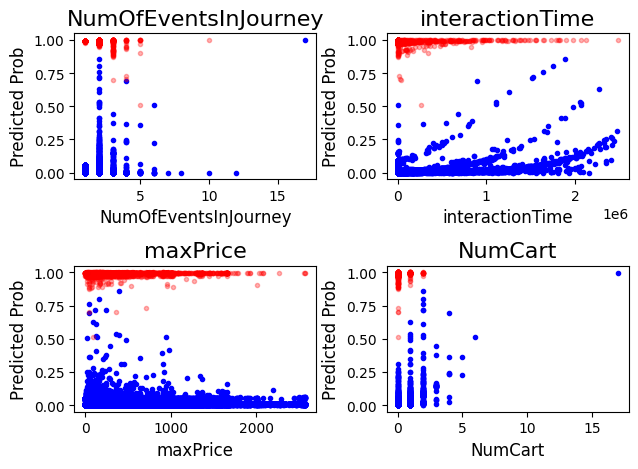

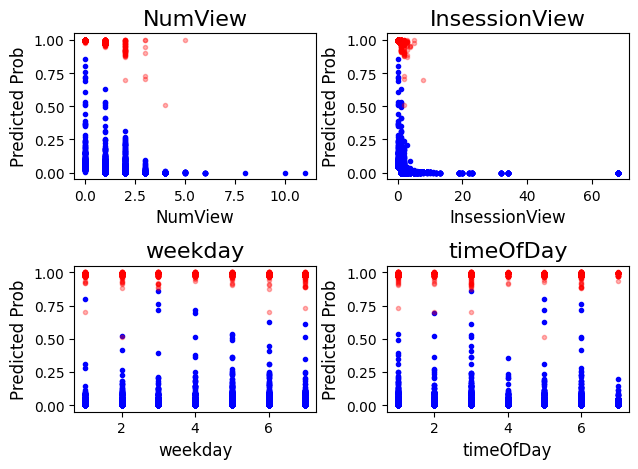

Text(0.5, 0, 'Predicted Purchase Prob')

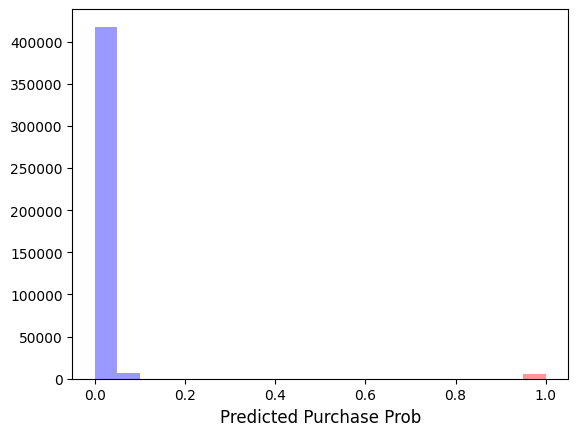

In [31]:
spi = 0
no_purchase = test_df_reduced.Purchase == 0
X_original = scaler.inverse_transform(X_test_reduced)


str_delin = '---------------------'
print( f'{str_delin}\nLegend:\nRed = True Purchase\nBlue = No purchase\n{str_delin}')
for col_i in np.arange( len(test_df_reduced.columns) -1):
    spi += 1
    if spi > 4:
        plt.tight_layout();
        plt.show();
        spi = 1
    if spi == 1:
        plt.figure();

    

    plt.subplot(2,2,spi)
    plt.plot( X_original[no_purchase  , col_i ] , lr_pred_proba[no_purchase,1] , '.b' ) ;
    plt.plot( X_original[~no_purchase , col_i ] , lr_pred_proba[~no_purchase,1] , '.r' , alpha = .3 ) ;
    
    plt.title( test_df_reduced.columns[col_i] , fontsize = 16 )
    plt.xlabel( test_df_reduced.columns[col_i] , fontsize = 12 )
    plt.ylabel( 'Predicted Prob' , fontsize = 12 )



plt.tight_layout();
plt.show();

# Plot predicted prob distribution by purchase group
plt.figure()
plt.hist( lr_pred_proba[no_purchase,1] , np.arange(0, 1.05 , .05 ) , color = 'b' , alpha = .4 );
plt.hist( lr_pred_proba[~no_purchase,1] , np.arange(0, 1.05 , .05 ) , color= 'r' , alpha = .4 );
plt.xlabel( 'Predicted Purchase Prob' , fontsize = 12 )



2. Calculate these classification metrics for the Logistic Regression model:

    * accuracy
    * precision
    * recall
    * f1 score
    * confusion matrix

In [32]:
print("accuracy:", accuracy(y_test, lr_pred))
print("precision:", precision(y_test, lr_pred))
print("recall:", recall(y_test, lr_pred))
print("f1 score:", f1_score(y_test, lr_pred))

print("\nconfusion matrix:")
print(confusion_matrix(y_test, lr_pred))

print("\nconfusion matrix (percentages):")
print( np.round( confusion_matrix(y_test, lr_pred) / len(lr_pred) * 100 , 2) )

accuracy: 0.9999651603552715
precision: 0.9975550122249389
recall: 1.0
f1 score: 0.9987760097919216

confusion matrix:
[[424409     15]
 [     0   6120]]

confusion matrix (percentages):
[[98.58  0.  ]
 [ 0.    1.42]]


3. Instantiate, train and predict using the SVM model. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) for usage. 

    Again, remember to account for the class imbalance.

In [33]:
%%time
svm_model = LinearSVC() # YOUR CODE HERE 
svm_model.fit(X_train_reduced, y_train)
svm_pred = svm_model.predict(X_test_reduced)

CPU times: user 7.64 s, sys: 160 ms, total: 7.8 s
Wall time: 7.99 s


4. ❓ What is the time complexity of SVM? What is it for Logistic Regression? Not familiar with the term "time complexity"? Take a read on [Computational Complexity of ML Models
](https://medium.com/analytics-vidhya/time-complexity-of-ml-models-4ec39fad2770).

    YOUR ANSWER HERE
## General Comment
The time complexity to fit both of these models depends on the optimizer used.  
(I'm also assuming that we're talking about the time complexity of fitting the model.)  

## Logistic Regression
The default optimizer/solver for sklearn.linear_model.LogisticRegression is "L-BFGS" with an L2 penalty.  
This has an O(nk) complexity where...    
- n is the number of samples and 
- k is the number of features in the dataset. 
With fixed n or k, this means that complexity grows linearly with the other parameter.  


## SVM Linear Classifier
The default optimizer/solver for sklearn's LinearSVC model is "Liblinear".  
The default penalty function is "l2" (the L2 loss).  

From the documentation (https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html), "Linear Support Vector Classification. Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples."

The "Liblinear" solver is a Coordinate Descent optimizer. It looks like this is an O(nk) complexity algorithm as well, where...    
- n is the number of samples and 
- k is the number of features in the dataset. 
With fixed n or k, this means that complexity grows linearly with the other parameter.  

This appears to be a special case of the LinearSVC. So this optimizer is not idea when the decision boundary is non-linear. In the event of non-linear decision boundaries, it would be different SVM model and/or a different optimizer.


5. Calculate the classification metrics for the SVM model. 

Here you can use a helper function to display all the metrics. 

Inspect the source code to understand how to use the function. 

In [34]:
from utils import display_metrics

print("accuracy:", accuracy(y_test, svm_pred))
print("precision:", precision(y_test, svm_pred))
print("recall:", recall(y_test, svm_pred))
print("f1 score:", f1_score(y_test, svm_pred))

print("\nconfusion matrix:")
print(confusion_matrix(y_test, svm_pred))

print("\nconfusion matrix (percentages):")
print( np.round( confusion_matrix(y_test, svm_pred) / len(svm_pred) * 100 , 2) )

accuracy: 1.0
precision: 1.0
recall: 1.0
f1 score: 1.0

confusion matrix:
[[424424      0]
 [     0   6120]]

confusion matrix (percentages):
[[98.58  0.  ]
 [ 0.    1.42]]


Wow, that's impressive! Why do you think SVM performs so well? If you are not familiar with Support Vector Machine, check [In-Depth: Support Vector Machines](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb) out for better understanding. 

## Task 5: Explanability with SHAP

Intepretation of a linear model such as logistic regression is staightforward, however, some tree-based models have a different reputation. In this task, we will fit a non-linear classifier: begin with gradient boosted tree, and use SHAP to help intepret the model. 

1. What are training coefficients from logistic regression? ( how about SVM? check [How does one interpret SVM feature weights?](https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights) )

    Leave your comments on interpretation of this logistic regression model.

In [35]:
# YOUR CODE HERE

# Coefficients of Logistic Regression
coef_names = ['Intercept'] +  list(train_df_reduced.drop( columns=['Purchase']).columns)
coef_vals = list(lr_model.intercept_) + list(lr_model.coef_[0] )

print('Logistic Reg Coefficients ')
display( pd.DataFrame( data = [coef_vals] , columns = coef_names , index = [0] ) )

Logistic Reg Coefficients 


,Intercept,NumOfEventsInJourney,interactionTime,maxPrice,NumCart,NumView,InsessionView,weekday,timeOfDay
0,5.107465,95.407015,5.589221,0.137431,-72.70908,-89.568773,-15.365448,0.091388,-0.143861


## Logistic Regression Coefficients
- The outcome variable (Y) is a purchase (0,1). Logistic regression maps the predictor varaibles to the log-odds of a purchase.
- Logistic regression coefficients map the rate of change in the *log* odds of Y as a the respective feature in X increments by 1 unit (while all other features are held constant).
- Note that this means the the effect of each unit change of that variable is linear & constant...which, typically, is not a reasonable assumption, even if it approximates the correct data generative function.
- Due to the [0,1] scaling of the feature space, a 1 unit movement in the feature-space is equivalent to moving the distance between the minimum and maximum value of that feature in the training set.
- The intercept is the log-odds of a purchase when all predictive features are at 0. Given that each feature was scaled to [0,1], this means the log-odds of when each feature is at the minimum value of that feature in the training set.
- On that note, recall that due to the scaling, the "unit" change in a feature is not the original units of the features, but the scaled units.
- Similarly, on the topic of units, the magnitude of each coefficient doesn't really tell you the importance of that feature (whether scaled or unscaled)
- I tried to get the p-values or standard errors for each coefficient, but couldn't figure it out.

## Coefficient Value Meanings
- Intercept = 5.107465 means that when all X=0, the probability of a purchase is exp(5.107465) / (1 + exp(5.107465) ) = 0.996. Since the overall low probability of a purchase is small, this means that the overall effect of most coefficients wll be to reduce the probability of a purchase.
- NumCart, NumView, InsessionView, timeOfDay all reduce the log-odds of a purchase as they increase.
- interactionTime, maxPrice, weekday all increase the log-odds of a purchase as they increase.

In [36]:
print('SVM Linear Classifier coefficients')
# print(train_df_reduced.columns)
# print(svm_model.coef_)

print( pd.DataFrame( data = svm_model.coef_ , 
                     columns = list(train_df_reduced.drop( columns=['Purchase']).columns) , index = [0] ) )
print( f'Intercept: { svm_model.intercept_}' )

coefs = svm_model.coef_[0]

print('\nEquations for Hyperplane Separating Classes')
for i in np.arange( len(coefs) ):
    for j in np.arange( i+1 , len(coefs) ):
        m = np.round( -1*coefs[i] / coefs[j] , 3 )
        b = np.round( svm_model.intercept_[0] / coefs[j] , 3 )
        print( f'Feature {train_df_reduced.columns[i].center(25)} vs {train_df_reduced.columns[j].center(25)}: y = { m } * x - { b }'  )



SVM Linear Classifier coefficients
   NumOfEventsInJourney  interactionTime  maxPrice    NumCart    NumView  \
0             21.120749          0.10444  0.000119 -17.755055 -17.634399   

   InsessionView   weekday  timeOfDay  
0      -1.243837  0.000082  -0.000095  
Intercept: [0.97795562]

Equations for Hyperplane Separating Classes
Feature    NumOfEventsInJourney   vs      interactionTime     : y = -202.229 * x - 9.364
Feature    NumOfEventsInJourney   vs          maxPrice        : y = -177064.394 * x - 8198.626
Feature    NumOfEventsInJourney   vs          NumCart         : y = 1.19 * x - -0.055
Feature    NumOfEventsInJourney   vs          NumView         : y = 1.198 * x - -0.055
Feature    NumOfEventsInJourney   vs       InsessionView      : y = 16.98 * x - -0.786
Feature    NumOfEventsInJourney   vs          weekday         : y = -257922.418 * x - 11942.601
Feature    NumOfEventsInJourney   vs         timeOfDay        : y = 223168.174 * x - -10333.373
Feature      interactionTim

## SVM Linear Classifier Coefficients
General Interpretation
- The SVM create a hyperplane that maximizes the separation between the classes.
- There is 1 single coefficient for each feature in the feature set, plus an intercept.
- the SVM hyperplane that separates the classes is defined by: y = -(coef_0 / coef_1) x - intercept/coef_1
- In the cell above, you can see what this means for our SVM.

Interpretation of this model's coefficients
- Positive coefficients indicate that  NumOfEventsInJourney, interactionTime, maxPrice, & weekday are positively associated with a purchase.
- NumOfEventsInJourney and interactionTime have the strongest postive influence.
- Negative coefficients indicate that NumCart, NumView, and InsessionView are negatively associated with a purchase.
- NumCart and NumView have the strongest negative influence.

2. Instantiate, train, and predict using the Gradient Boosted Trees model.

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
%%time
gbt_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                     max_depth=1, random_state=0) # YOUR CODE HERE
gbt_model.fit(X_train_reduced, y_train)
gbt_pred = gbt_model.predict(X_test_reduced)


CPU times: user 22.2 s, sys: 1.02 s, total: 23.2 s
Wall time: 23.5 s


3. Evaluate the model by calculating the classification metrics.

In [39]:
# YOUR CODE HERE
print("accuracy:", accuracy(y_test, gbt_pred))
print("precision:", precision(y_test, gbt_pred))
print("recall:", recall(y_test, gbt_pred))
print("f1 score:", f1_score(y_test, gbt_pred))

print("\nconfusion matrix:")
print(confusion_matrix(y_test, gbt_pred))

print("\nconfusion matrix (percentages):")
print( np.round( confusion_matrix(y_test, gbt_pred) / len(gbt_pred) * 100 , 2) )

accuracy: 0.9973312832137946
precision: 0.8612120331347188
recall: 0.9683006535947712
f1 score: 0.9116221829090071

confusion matrix:
[[423469    955]
 [   194   5926]]

confusion matrix (percentages):
[[9.836e+01 2.200e-01]
 [5.000e-02 1.380e+00]]


4. SHAP (SHapley Additive exPlanations) is a game theory approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. You can use package [SHAP](https://github.com/slundberg/shap). 

    For this task, if you are not familar with the concept, read the book chapter [Interpretable Machine Learning - A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/shap.html) first. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


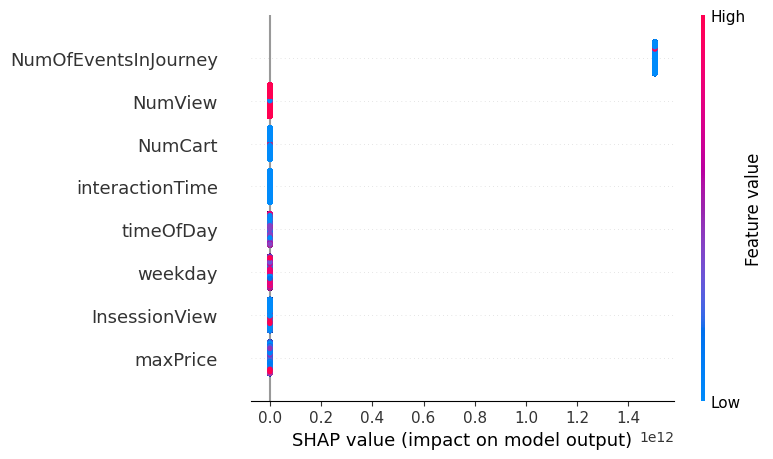

In [40]:
# Here is the example of Shap by Yifei Huang
# From: https://towardsdatascience.com/demystify-your-ml-model-with-shap-fc191a1cb08a
# load JS visualization code to notebook
import shap

shap.initjs()

explainer = shap.TreeExplainer(gbt_model)

shap_values = explainer.shap_values( train_df_reduced.drop(columns=['Purchase']) )

shap.summary_plot( shap_values, train_df_reduced.drop(columns=['Purchase'])  )

5. Consider experimenting on a smaller dataset. 

For example, start with a subset of 100 samples from the test data.

Once the script works properly, use all the data from `X_test_reduced`. 

Apply `shap.Explainer()` to calculate the SHAP values for the Gradient Boosting classifier you fit earlier.

In [41]:
# This runs fast enough that a sub-sampling isn't needed
# I'll use a 10x reduction for this demo

train_df_reduced_subset = train_df_reduced[::10].copy(deep=True)

print(f'Training Data Set Size: {train_df_reduced.shape}')
print(f' Reduced Data Set Size: {train_df_reduced_subset.shape}')
print(f'Reduction factor: {train_df_reduced_subset.shape[0] / train_df_reduced.shape[0] }')



Training Data Set Size: (645816, 9)
 Reduced Data Set Size: (64582, 9)
Reduction factor: 0.10000061937146185


In [42]:
import shap
explainer = shap.TreeExplainer(gbt_model) # YOUR CODE HERE

In [43]:
%%time
shap_values = explainer.shap_values( train_df_reduced_subset.drop(columns=['Purchase']) ) # YOUR CODE HERE

CPU times: user 1.21 s, sys: 26.7 ms, total: 1.24 s
Wall time: 1.31 s


6. visualize the effects over all samples using `shap.plots.beeswarm()` or `shap.summary_plot()`. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


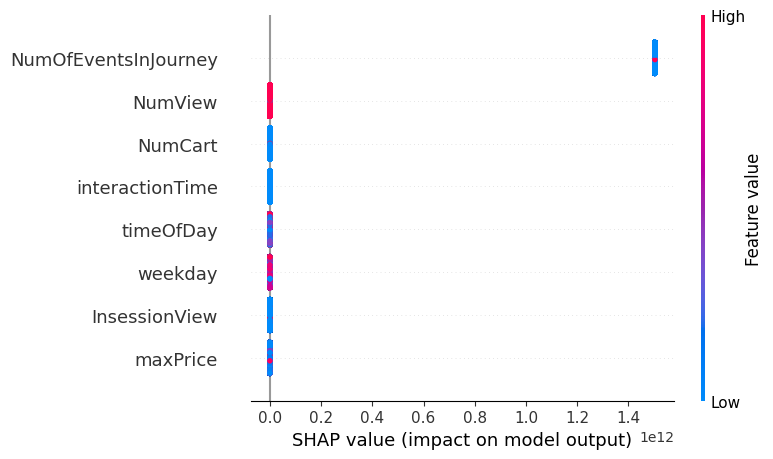

In [44]:
# YOUR CODE HERE
shap.summary_plot( shap_values, train_df_reduced_subset.drop(columns=['Purchase'])  )

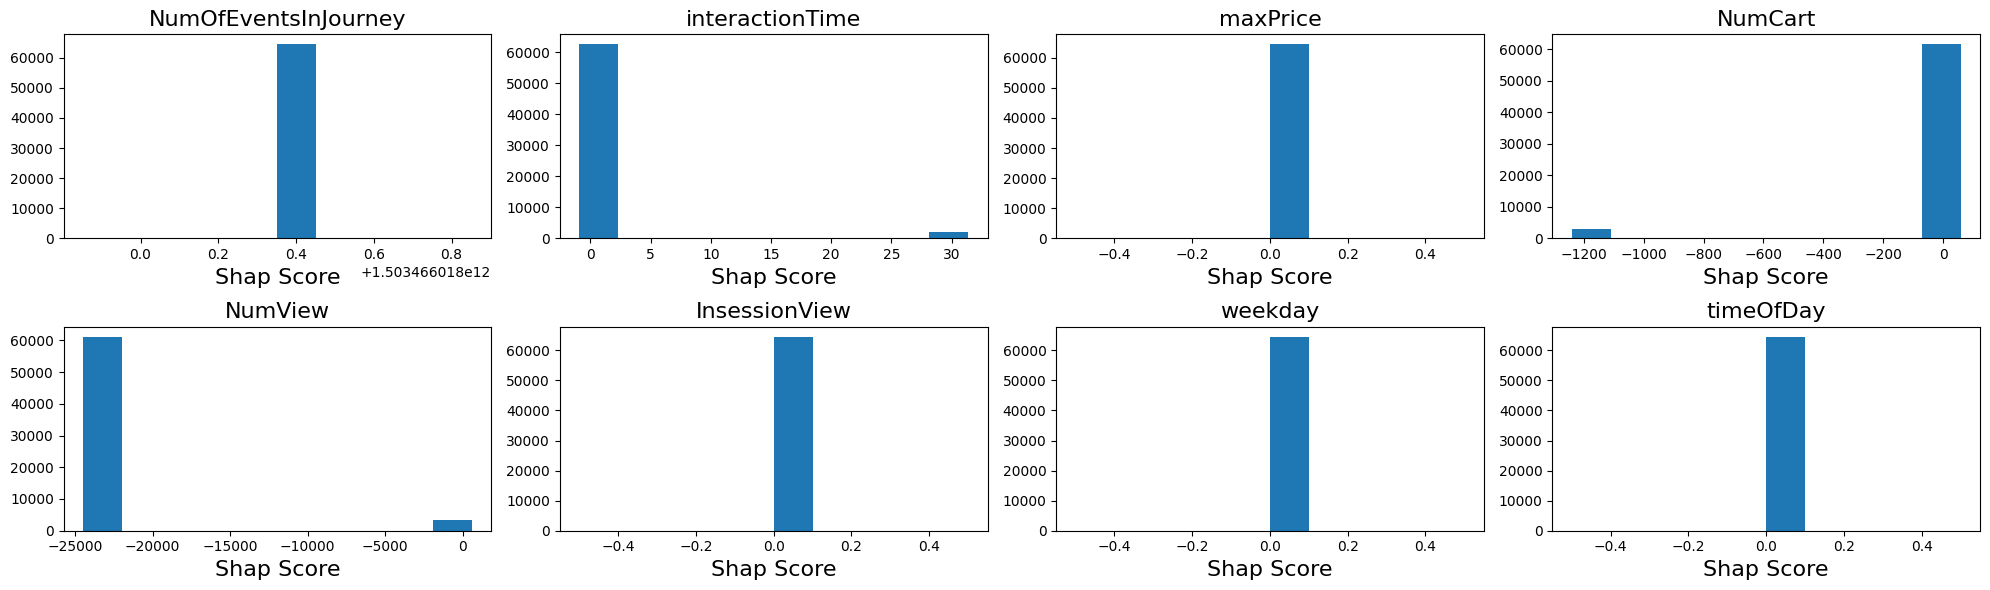

In [45]:
plt.figure(figsize=(20,6))
for i in np.arange( shap_values.shape[1] ):
    plt.subplot(2,4,i+1)
    plt.hist( shap_values[:,i])
    plt.title( train_df_reduced_subset.columns[i] , fontsize = 16 )
    plt.xlabel( 'Shap Score' , fontsize = 16 )

plt.tight_layout()
plt.show()

7. What are features 4, 3, and 1? Does each feature positively or negatively contribute to the likelihood of purchase?

Features 4, 3, and 1 respectively.
['NumView' 'NumCart' 'interactionTime']


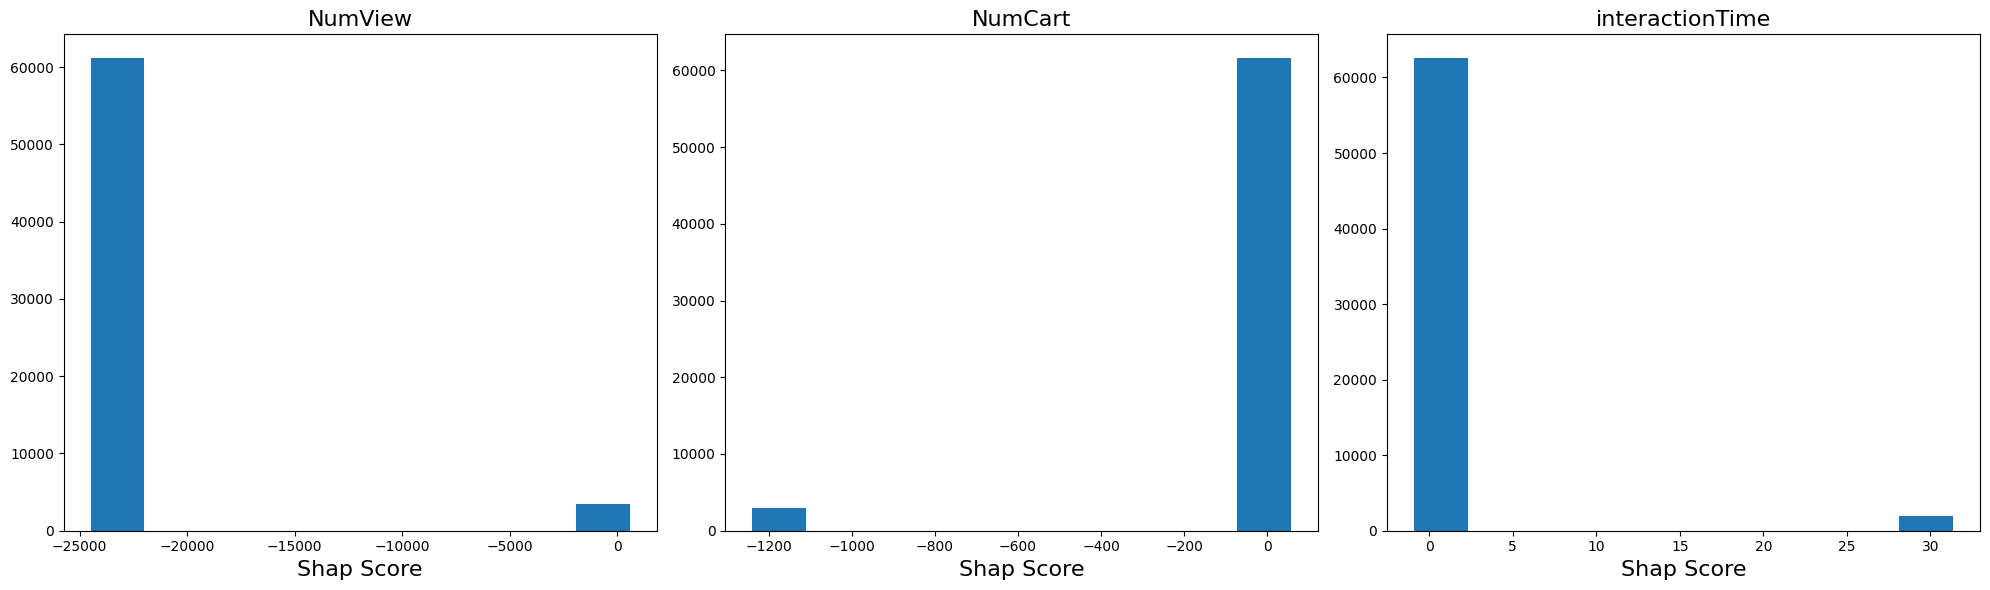

In [46]:
# YOUR CODE HERE
print('Features 4, 3, and 1 respectively.')
print( train_df_reduced.columns[[4,3,1]].values )

plt.figure(figsize=(20,6))
for i in [4,3,1]:
    plt.subplot(1,3, [4,3,1].index(i)+1 )
    plt.hist( shap_values[:,i])
    plt.title( train_df_reduced_subset.columns[i] , fontsize = 16 )
    plt.xlabel( 'Shap Score' , fontsize = 16 )

plt.tight_layout()
plt.show()

##  Commentary
- For Num View, the feature has little influence on a small number of data points and a large negative effect (on probability of purchase) on most data points.
- For NumCart, the feature has little influence on most data points and a large negative effect (on probability of purchase) on a small portion data points.
- For interactiontime, the feature has little influence on most data points and a positive effect (on probability of purchase) on a small portion data points.


8. Visualize the effects over all samples using `shap.plots.beeswarm()` or `shap.summary_plot()`. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


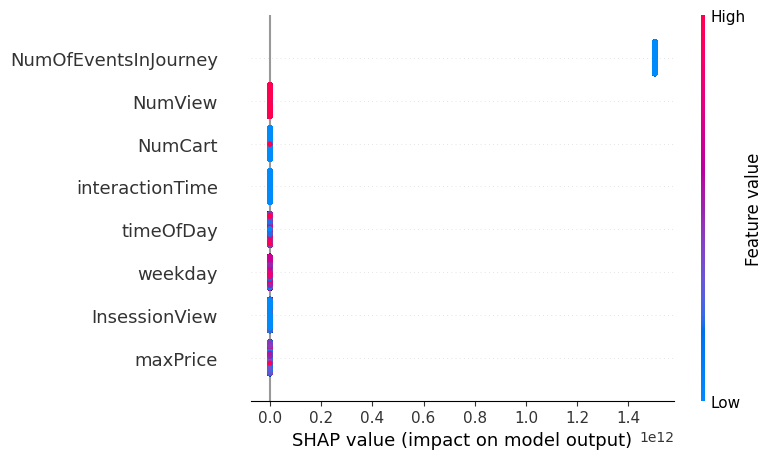

In [47]:
# YOUR CODE HERE
explainer = shap.TreeExplainer(gbt_model)
shap_values = explainer.shap_values( train_df_reduced.drop(columns=['Purchase']) )
shap.summary_plot( shap_values, train_df_reduced.drop(columns=['Purchase'])  )

9. Write your data (shap values) to a file and add them under the Model Explainability tab in the Streamlit app (see next section), following the example in Model Results tab.

In [48]:
# Write shap values as csv
df_temp = pd.DataFrame( shap_values , columns = train_df_reduced.drop(columns=['Purchase']).columns )
df_temp['target'] = train_df_reduced.Purchase
df_temp.to_csv('../dat/shapvals.csv')

display( df_temp )

,NumOfEventsInJourney,interactionTime,maxPrice,NumCart,NumView,InsessionView,weekday,timeOfDay,target
0,1.503466e+12,-0.92045,0.0,58.266996,-24490.039153,0.0,0.0,0.0,0
1,1.503466e+12,-0.92045,0.0,58.266996,-24490.039153,0.0,0.0,0.0,0
2,1.503466e+12,-0.92045,0.0,58.266996,-24490.039153,0.0,0.0,0.0,0
3,1.503466e+12,-0.92045,0.0,58.266996,-24490.039153,0.0,0.0,0.0,0
4,1.503466e+12,-0.92045,0.0,58.266996,-24490.039153,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
645811,1.503466e+12,-0.92045,0.0,58.266996,-24490.039153,0.0,0.0,0.0,0
645812,1.503466e+12,-0.92045,0.0,58.266996,-24490.039153,0.0,0.0,0.0,0
645813,1.503466e+12,-0.92045,0.0,58.266996,-24490.039153,0.0,0.0,0.0,0
645814,1.503466e+12,-0.92045,0.0,58.266996,-24490.039153,0.0,0.0,0.0,0


10. Optional. Do the same for a random forest model.

## Task 6: AutoML

Let's see how AutoML performs on this imbalanced dataset. Similarly, for faster iteration on our workflow, experiment it on a small smaple. 

1. Take 5,000 samples from `train_df`, 5,000 from `test_df` for experimenting.

In [49]:
train_features = train_df.sample(int(5e3), random_state=42)
train_label = train_features.pop('Purchase')
test_features = test_df.sample(int(5e3), random_state=42)
test_label = test_features.pop('Purchase')

2. Instantiate and train a TPOT auto-ML classifier.

    The parameters in the code below are set to low values for faster iterations. 
    Read about each parameters [here](http://epistasislab.github.io/tpot/api/#classification) and experiment with different values when time permits.
    
    Set a proper [`scoring` function](http://epistasislab.github.io/tpot/using/#scoring-functions). 

In [50]:
'''
Scoring Options for tpot
Source: https://epistasislab.github.io/tpot/api/
'accuracy', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 
'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'neg_log_loss', 'precision' etc. 
(suffixes apply as with ‘f1’), 'recall' etc. (suffixes apply as with ‘f1’), ‘jaccard’ etc. (suffixes apply as with ‘f1’), 
'roc_auc', ‘roc_auc_ovr’, ‘roc_auc_ovo’, ‘roc_auc_ovr_weighted’, ‘roc_auc_ovo_weighted’
'''

"\nScoring Options for tpot\nSource: https://epistasislab.github.io/tpot/api/\n'accuracy', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', \n'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'neg_log_loss', 'precision' etc. \n(suffixes apply as with ‘f1’), 'recall' etc. (suffixes apply as with ‘f1’), ‘jaccard’ etc. (suffixes apply as with ‘f1’), \n'roc_auc', ‘roc_auc_ovr’, ‘roc_auc_ovo’, ‘roc_auc_ovr_weighted’, ‘roc_auc_ovo_weighted’\n"

In [51]:
%%time
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=5, # 
                      population_size=16, # Number of individuals to retain in the genetic programming population every generation. Must be a positive number.
                      scoring= 'roc_auc',# YOUR CODE HERE
                      verbosity=2,
                      random_state=42)
tpot.fit(train_features, train_label)
print(f"Tpop score on test data: {tpot.score(test_features, test_label):.2f}")
tpot.export('tpot_electronics_pipeline.py')

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


Optimization Progress:   0%|          | 0/96 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 1.0

Generation 2 - Current best internal CV score: 1.0

Generation 3 - Current best internal CV score: 1.0

Generation 4 - Current best internal CV score: 1.0

Generation 5 - Current best internal CV score: 1.0

Best pipeline: GradientBoostingClassifier(FastICA(input_matrix, tol=0.35000000000000003), learning_rate=0.1, max_depth=7, max_features=0.4, min_samples_leaf=17, min_samples_split=14, n_estimators=100, subsample=0.35000000000000003)


sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.


Tpop score on test data: 1.00
CPU times: user 5min 40s, sys: 1min 5s, total: 6min 46s
Wall time: 3min 33s


3. Examine the model pipeline that TPOT classifier offers in the python file `tpot_electronics_pipeline.py` in the `nb` directory. 
If you see any model, function, or class that are not familiar, look them up!

    Note: There is randomness to the way the TPOT searches, so it's possible you won't have exactly the same result as your classmate.

In [52]:
!cat tpot_electronics_pipeline.py # A sample output

import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: 1.0
exported_pipeline = make_pipeline(
    FastICA(tol=0.35000000000000003),
    GradientBoostingClassifier(learning_rate=0.1, max_depth=7, max_features=0.4, min_samples_leaf=17, min_samples_split=14, n_estimators=100, subsample=0.35000000000000003)
)
# Fix random state for all the steps in exported pipeline
s

4. Take the appropriate lines (e.g., updating path to data and the variable names) from `tpot_electronics_pipeline.py` to build a model on our training set and make predictions on the test set. 

    Choose approriate metrics to evaluate the prediction from TPOT. 
    
    Optional. Add this to Streamlit `models` in the next section.

## Advanced Visualizations with Streamlit and Plotly!
Let's visualize our results in a way that makes it easy to compare our models!  
[Streamlit](https://streamlit.io/) is a Python package that makes it easy to create bespoke, dynamic and interactive web apps for visualizations.  
Lightweight web apps like this are a great way to present results to stakeholders! 

First we need to build our results dataset to render in Streamlit.

In [53]:
from collections import defaultdict

results_data = defaultdict(list)

models = ["Logistic Regression", "SVM", "Gradient Boosting Classifier"]

for model, pred in zip(models, [lr_pred, svm_pred, gbt_pred]):
    confusion = confusion_matrix(y_test, pred)
    accuracy_ = accuracy(y_test, pred)
    recall_ = recall(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    results_data['model'].append(model)
    results_data['tn'].append(confusion[0][0])
    results_data['fp'].append(confusion[0][1])
    results_data['fn'].append(confusion[1][0])
    results_data['tp'].append(confusion[1][1])
    results_data['accuracy'].append(accuracy_)
    results_data['recall'].append(recall_)
    results_data['f1_score'].append(f1)
results_df = pd.DataFrame(results_data)
results_df

,model,tn,fp,fn,tp,accuracy,recall,f1_score
0,Logistic Regression,424409,15,0,6120,0.999965,1.000000,0.998776
1,SVM,424424,0,0,6120,1.000000,1.000000,1.000000
2,Gradient Boosting Classifier,423469,955,194,5926,0.997331,0.968301,0.911622


In [54]:
# Write our results_df to CSV
results_df.to_csv("../dat/model_results.csv")

2. Then, we need to built Stremlit app. 
For today's assignment, we wrote the code for you.
However, understand the code in `electronics_purchase_predictions_stremlit.py` because you might need to write a Streamlit web app on your own for the future assignments. 

3. Once you inspected the code, you will need to start streamlit from CLI. 
Try looking up how to do this yourself.

HINT: this is a python file - maybe if you run it as a python file from the CLI, it will give you further instructions. 

Note - once you run the stremlit, the prompt will ask you to provide an email. 
You can leave the email blank. 

And you are done! 

## References

- This work is motivated by this [publication](https://arxiv.org/pdf/2010.02503.pdf) 
- [Comprehensive Guide on Feature Selection](https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection/notebook)
- [Common pitfalls and recommended practices](https://scikit-learn.org/stable/common_pitfalls.html)
- [Interactive Shapley Value Demonstration in Python](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/Interactive_Shapley_Values.ipynb)
- [Subsurface Data Analytics](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Feature_Ranking.ipynb)

## Algorithm Understanding
### Is SVM (Support Vector Machine) a supervised or unsupervised learning algorithm?
An SVM is a supervised learning algorithm.  
In maps inputs X to labeled outputs Y.  
SVMs can be used for regression & classification problems (with appropriate adjustments to the learning task).

### Why is SVM such a powerful classification method?
"Power" or "success" at a clasification task occurs on a case by casy basis.  
However, one reasons that an SVM might succeed over other methods is that it is a kernel-based method. This gives it advantages including  
(i) not imputing a linear form on the response function where the assumption of linearity is unrealistic, and
(ii) relatedly, the kernel trick might find better separation in kernel / non-linear space, and
(iii) direct over-fitting via over-parameterization might be harder / more obvious.

### What are 3 disadvantages of SVMs?
Some disadvantages...
(i) There's no probabilistic component to the model (it's not a probabilistic method). This means the uncertainty in the prediction is less straight-forward, as is interpreting the uncertainty of the model parameters.

(ii) Model parameter interpretation is nowhere near as easy as methods like regression. No ceteris paribus to make the interpreations simple. It's a system of equations.

(iii) Kernel choice & sensitivity: Obviously, it's always helpful to understand how the data, model choice, and inference/model-fitting algo all fit together. But I've always found tuning SVM kernels much harder to intuit than, say, kernels for Gaussian processes. Since SVM performance can be very sensitive to kernel choice, this adds to the challenge of hand-tuning to select a model. (I don't know if auto-training/tuning methods help address this issue.)

(iv) Multiclass problems: Need to stack multiple binary SVMs together.

## Interview Readiness
### What is the time complexity of SVM?
The default optimizer/solver for sklearn's LinearSVC model is "Liblinear".  
The default penalty function is "l2" (the L2 loss).  

From the documentation (https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html), "Linear Support Vector Classification. Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples."

The "Liblinear" solver is a Coordinate Descent optimizer. It looks like this is an O(nk) complexity algorithm as well, where...    
- n is the number of samples and  
- k is the number of features in the dataset.  
With fixed n or k, this means that complexity grows linearly with the other parameter.  

This appears to be a special case of the LinearSVC. So this optimizer is not idea when the decision boundary is non-linear. In the event of non-linear decision boundaries, it would be different SVM model and/or a different optimizer.


### What is it for Logistic Regression?
The default optimizer/solver for sklearn.linear_model.LogisticRegression is "L-BFGS" with an L2 penalty.  
This has an O(nk) complexity where...    
- n is the number of samples and 
- k is the number of features in the dataset. 
With fixed n or k, this means that complexity grows linearly with the other parameter.  

## General Comment
The time complexity to fit both of these models depends on the optimizer used.  
(I'm also assuming that we're talking about the time complexity of fitting the model.)  


## Interview Readiness
### Explain feature importance for the Random Forest algorithm?
For context, Random Forests are comprised of numerous decision trees. Each tree "branches" by splitting the node (in the feature space) at the location that minimizes the impurity of the resulting nodes. low-impurity nodes are important because it means that that the node describes its data points well.  

A feature that (i) is frequently used to make a split or (ii) consistently results in large reductions of impurity is *important* because this means that it is able to sort on X to get similar Ys in a node.   

### When examining feature importance, what is Gini impurity or information gain?
To help with intuition, remember that the Gini coefficient began as an economic statistic to describe income inequality. A score of 0 means perfect equality, everyone has the same income...the same value. A Gini of 1 means maximally inequal income (1 person has all of the money, and the rest have 0). So if you had a population with a distribution of incomes and split that population into two subpopulations of low and high incomes, then each of those two subpopulations would have a lower Gini (impurity) than the population as a whole (because the two subpopulations are more tightly grouped).  

The difference of the Gini example above and its use in Random forest is that now we're splitting the population based on a feature (X, the predictor) according to its Gini affect on a different variable (Y, the outcome).  When a feature (X) value is highly predictive of Y then using that feature to split the feature space will reduce the Gini of the resultant nodes *more* than a less-predictive feature. In other words the important feature, across many decision trees, will reduce the variation in Y at each node.



## Interview Readiness
### SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model, what is it and how does it work?

The key to understanding SHAP is the SHAP values, which are meant to describe that feature's influence on the outcome of each observation.   
Each feature has a shap value for each observation. Values close to 0 indicate that the feature had little effect on the outcome for that observation. High values indicate the feature pushed that particular observation towards the 1 class. A negative values indicates that the feature pushed the observation towards the 0 class.

It looks like the SHAP values are calculated by taking all subsets of all features and comparing the expect outcome Y of the subsets that contain feature X to the expected outcome Y of the subsets that don't include feature X. In this way, the difference in the expectations describes how strongly that feature influences the outcome.
